consider coding dates as (years ago) instead of years, because for clustering it may consider it differently

# Data Setup

In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', False)
pd.set_option('display.max_rows', False)

library = pd.read_csv('library.csv')
tracks = pd.read_csv('tracks.csv')
features = pd.read_csv('features.csv')
artists = pd.read_csv('artists.csv')

print('Library: ', library.columns)
print('Tracks: ', tracks.columns)
print('Features: ', features.columns)
print('Artists: ', artists.columns)

Library:  Index(['track.trackName', 'track.artistName', 'track.trackUri', 'track.id'], dtype='object')
Tracks:  Index(['artists', 'available_markets', 'disc_number', 'duration_ms',
       'explicit', 'href', 'id', 'is_local', 'name', 'popularity',
       'preview_url', 'track_number', 'type', 'uri', 'album.album_type',
       'album.artists', 'album.available_markets',
       'album.external_urls.spotify', 'album.href', 'album.id', 'album.images',
       'album.name', 'album.release_date', 'album.release_date_precision',
       'album.total_tracks', 'album.type', 'album.uri', 'external_ids.isrc',
       'external_urls.spotify', 'artist.id'],
      dtype='object')
Features:  Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms',
       'time_signature'],
      dtype='object')
Artists:  Index(['genres', 'href', 'id', 'imag

In [2]:
library = library.rename(columns={
    'track.trackName': 'track.name',
    'track.trackUri': 'track.uri',
    })

tracks = tracks[['uri', 'artist.id','available_markets', 'explicit', 'popularity','track_number','album.album_type','album.release_date','album.total_tracks']]

tracks = tracks.rename(columns={
    'uri': 'track.uri',
    'available_markets': 'track.available_markets',
    'explicit': 'track.explicit',
    'popularity': 'track.popularity',
    'track_number': 'track.track_number',
})

features = features[['id','danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
'type',  'duration_ms', 'time_signature']]

features = features.rename(columns={
    'id': 'track.id',
    'danceability': 'track.danceability',
    'energy': 'track.energy',
    'key': 'track.key',
    'loudness': 'track.loudness',
    'mode': 'track.mode',
    'speechiness': 'track.speechiness',
    'acousticness': 'track.acousticness',
    'instrumentalness': 'track.instrumentalness',
    'liveness': 'track.liveness',
    'valence': 'track.valence',
    'tempo': 'track.tempo',
    'type': 'track.type',
    'duration_ms': 'track.duration_ms',
    'time_signature': 'track.time_signature'
})

artists = artists[['id','genres','followers.total','popularity']]
artists = artists.rename(columns={
    'id': 'artist.id',
    'genres': 'artist.genres',
    'followers.total': 'artist.followers_total',
    'popularity': 'artist.popularity'
})

In [3]:
artists.head()

,artist.id,artist.genres,artist.followers_total,artist.popularity
0,100sLnojEpcadRx4edEBA6,"['alt z', 'electropop', 'gauze pop', 'indie po...",440752,53
1,4YZ5ECfbM2xSTSQTJGBbO5,[],458920,48
2,5t28BP42x2axFnqOOMg3CM,"['alternative metal', 'groove metal', 'nu metal']",6292591,71
3,20JZFwl6HVl6yg8a4H3ZqK,"['modern rock', 'pop']",12090153,75
4,0CbeG1224FS58EUx4tPevZ,"['australian dance', 'big room', 'melbourne bo...",1090084,69


In [4]:
from sklearn.preprocessing import MultiLabelBinarizer
import ast
artists['artist.genres'] = artists['artist.genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Initialize the MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Fit and transform the 'artist.genres' column
binary_genres = mlb.fit_transform(artists['artist.genres'])

# Create a DataFrame from the binary genres
binary_genres_df = pd.DataFrame(binary_genres, columns=mlb.classes_, index=artists.index)

# Concatenate the binary genres DataFrame with the original DataFrame
artists = pd.concat([artists, binary_genres_df], axis=1)

# Drop the old 'artist.genres' column
artists = artists.drop('artist.genres', axis=1)

In [5]:
df = pd.merge(library, tracks, on='track.uri', how='left')
df = pd.merge(df, features, on='track.id', how='left')
df = pd.merge(df, artists, on='artist.id', how='left')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2891 entries, 0 to 2890
Columns: 774 entries, track.name to zolo
dtypes: float64(764), object(10)
memory usage: 17.1+ MB


In [6]:
df['mix_remix'] = df['track.name'].str.contains('mix|remix', case=False)

In [7]:
df['album.release_date'] = pd.to_datetime(df['album.release_date'], infer_datetime_format=True, errors='coerce')

C:\Users\jesse\AppData\Local\Temp\ipykernel_33548\1074546538.py:1: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['album.release_date'] = pd.to_datetime(df['album.release_date'], infer_datetime_format=True, errors='coerce')


In [8]:
df['album_year_ago'] = 2023 - df['album.release_date'].dt.year
df.drop(columns=['album.release_date'], inplace=True)

In [9]:
df.dropna(inplace=True)

In [10]:
df_new = df.drop(columns=['track.artistName', 'track.uri', 'track.id', 'artist.id', 'track.available_markets', 'track.track_number', 'album.album_type', 'album.total_tracks', 'track.type'])
df_new.columns

Index(['track.name', 'track.explicit', 'track.popularity',
       'track.danceability', 'track.energy', 'track.key', 'track.loudness',
       'track.mode', 'track.speechiness', 'track.acousticness',
       ...
       'western americana', 'windsor on indie', 'wisconsin indie', 'world',
       'world worship', 'worship', 'yacht rock', 'zolo', 'mix_remix',
       'album_year_ago'],
      dtype='object', length=766)

## FAMD

In [11]:
import prince

# Initialize FAMD object
famd = prince.FAMD(n_components=100, random_state=42)  # adjust this based on your actual data

# Fit FAMD to the mixed data
famd = famd.fit(df)

# Calculate the explained variance ratio
explained_variance_ratio = famd.eigenvalues_ / sum(famd.eigenvalues_)

# Calculate the cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Find the number of components that explain at least 95% of the variance
n_components_95 = np.where(cumulative_explained_variance >= 0.95)[0][0] + 1

print('Number of components that explain at least 90% of the variance:', n_components_95)

c:\Users\jesse\anaconda3\Lib\site-packages\prince\pca.py:175: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[-1.7314857934264356, -0.5984323944474182, -1.2821215295120647, -0.06256112470898545, -0.04423739552038088, -0.15950019784171426, -0.08847479104076177, -0.07662141663581953, -0.13271218656114264, -0.1251222494179709, -0.11704114719613057, -0.10835904657461548, -0.09891782353111633, -0.18768337412695632, -0.21671809314923096, -0.34832560065325385, -0.19282633659877915, -0.2541244898865087, -0.17133069613002574, -0.14671884264365215, -0.37536674825391264, -0.17694958208152353, -0.42660999297446744, -0.23408229439226114, -2.2056678457538803, -0.367463405262941, -0.1655211777204736, -0.20272121351984576, -1.6798564844114445, -0.41967278279439957, -0.21215509594589552, -0.22556734298894415, -0.19783564706223267, -0.13989092759813318, -0.15324283327163907, -0.24229819411790596, -0.8287873394374106, -2.0545401016661144, -0.8825332688606092, -2.2360679774997

Number of components that explain at least 90% of the variance: 95


In [12]:
# Assuming df is your DataFrame and n_components is the number of components you want to keep
import prince

famd = prince.FAMD(n_components=n_components_95, random_state=42)

famd = famd.fit(df)  # fit the FAMD model

coordinates = famd.transform(df)

print(coordinates)

c:\Users\jesse\anaconda3\Lib\site-packages\prince\pca.py:175: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[-1.7314857934264356, -0.5984323944474182, -1.2821215295120647, -0.06256112470898545, -0.04423739552038088, -0.15950019784171426, -0.08847479104076177, -0.07662141663581953, -0.13271218656114264, -0.1251222494179709, -0.11704114719613057, -0.10835904657461548, -0.09891782353111633, -0.18768337412695632, -0.21671809314923096, -0.34832560065325385, -0.19282633659877915, -0.2541244898865087, -0.17133069613002574, -0.14671884264365215, -0.37536674825391264, -0.17694958208152353, -0.42660999297446744, -0.23408229439226114, -2.2056678457538803, -0.367463405262941, -0.1655211777204736, -0.20272121351984576, -1.6798564844114445, -0.41967278279439957, -0.21215509594589552, -0.22556734298894415, -0.19783564706223267, -0.13989092759813318, -0.15324283327163907, -0.24229819411790596, -0.8287873394374106, -2.0545401016661144, -0.8825332688606092, -2.2360679774997

component        0         1         2   ...         92         93        94
0         -0.987188 -1.538221  1.351033  ...   1.995478   4.626585  0.139070
1         -3.323378  3.104410  5.032627  ... -12.051731 -13.569966  1.765014
2         -0.460903 -1.461827 -0.287090  ...  -0.495670  -0.744421  0.079966
3         -2.348018 -1.172171  1.078848  ...  -1.397042  -1.383861 -1.726749
5         -0.387583 -2.083943  0.206626  ...  -0.205282  -2.598760 -0.531412
6         -2.567553 -0.169327  0.572487  ...   1.193334   0.019636 -1.166210
7          0.462808  2.870535  5.154072  ...  -1.326684   3.724403  0.124367
8         -1.347100 -0.402172 -0.658354  ...   0.014188  -0.284396  0.322849
9         -4.990235 -8.329294 -2.849263  ...  -1.625796  -0.142501 -0.082108
...             ...       ...       ...  ...        ...        ...       ...
2841      -2.095570  2.268991  4.801923  ...  -0.030092  -3.202800 -0.735707
2842      -0.516282  0.607265  5.155365  ...   3.656566  -1.640787 -1.802827

In [13]:
coordinates_df = pd.DataFrame(coordinates).copy()
coordinates_df['track.name'] = df['track.name']
coordinates_df['track.artistName'] = df['track.artistName']
coordinates_df['track.id'] = df['track.id']
coordinates_df.head(2)

component,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,track.name,track.artistName,track.id
0,-0.987188,-1.538221,1.351033,3.279820,-7.444957,1.560278,-1.062093,-8.607745,5.613410,6.905058,-4.631646,-0.570061,4.544429,0.426192,2.686399,-4.718323,-7.712292,4.916111,-11.341382,-8.717212,-8.688695,2.744188,-0.322410,-4.027017,0.243862,-5.231696,0.18501,7.017796,-10.392498,3.184836,11.784623,2.965092,-0.369005,3.207023,5.409390,-5.219110,3.412127,3.370713,-0.214449,2.315731,...,11.221579,-4.754434,1.746622,3.069095,-2.969153,2.563846,-0.183908,1.665999,-3.501808,3.433822,-0.698134,4.834682,3.115648,-2.246996,5.961344,1.309537,5.542080,3.845851,3.827638,0.036117,-5.801489,0.856461,0.420353,-1.659147,6.115750,-0.791284,-4.830578,-1.983534,-1.096895,2.630451,3.065195,0.561983,-3.490602,-1.876723,1.995478,4.626585,0.139070,Sweet Ophelia,Zella Day,1jPZgfC9tWFNf7iBGdrTPV
1,-3.323378,3.104410,5.032627,-6.038923,-1.170737,1.580957,3.339937,1.788602,5.718613,-1.322526,4.220405,0.798211,2.598099,-5.628695,2.116721,8.731633,3.902659,-1.562023,1.253362,5.571145,3.072081,6.225995,2.671257,6.646899,-1.061647,2.827478,6.72644,-5.278759,-7.904851,14.537145,2.863240,-10.641675,-0.609025,3.737743,1.818148,-3.783458,5.015635,3.809870,-1.059339,-1.633722,...,1.749382,-0.203858,6.994056,4.265199,3.063611,-8.970354,8.394510,-3.296672,7.749906,3.311081,2.756495,6.477468,0.664497,-1.250712,-0.962927,-6.423705,3.367787,0.978905,1.662133,-9.648533,-11.812188,-1.751085,6.416523,9.357449,6.962256,1.391871,12.833616,8.811360,-10.172092,2.408848,4.206537,-9.126000,5.827139,11.963652,-12.051731,-13.569966,1.765014,Hazy Shade of Winter (feat. Ray Toro),Gerard Way,1tBZnhDT8xbgJTs43FiqrD


# Modeling

### Normal k means

In [14]:
x = coordinates.copy()

In [15]:
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

inertia = []
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(x)
    inertia.append(np.sqrt(kmeans.inertia_))

c:\Users\jesse\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\jesse\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\jesse\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\jesse\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

Text(0, 0.5, 'Variance')

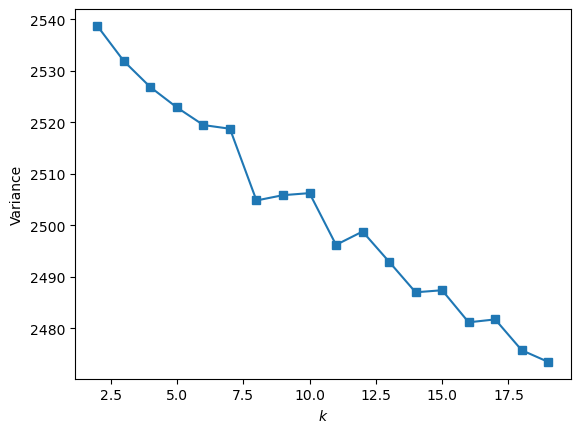

In [16]:
plt.plot(range(2,20), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('Variance')

In [17]:
#create KMeans model
kmeans = KMeans(n_clusters=17, random_state=1).fit(x)
y = kmeans.fit_predict(x)

c:\Users\jesse\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\jesse\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [18]:
#assign cluster labels to coordinates dataframe
coordinates_df['cluster'] = y

In [19]:
coordinates_df['cluster'].value_counts()

cluster
15    961
13    388
6     350
1     339
7     263
9     159
14     39
2      11
5      11
10      9
8       7
4       7
11      5
0       3
3       1
12      1
16      1
Name: count, dtype: int64

In [20]:
# # Start with a minimum number of clusters
# weird = []
# n_clusters = 15

# while True:
#     kproto = KPrototypes(n_clusters=n_clusters, random_state=42)
#     clusters = kproto.fit_predict(x, categorical=categorical_indices)
#     cluster_sizes = np.bincount(clusters)
#     if np.all((cluster_sizes >= 15) & (cluster_sizes <= 250)):
#         break
#     #if one or more clusters have less than 3 members, add those 3 members to 'weird' and remove them from x
#     else:
#         for i in range(len(cluster_sizes)):
#             if cluster_sizes[i] < 5:
#                 weird.append(x[clusters == i])
#                 x = x[clusters != i]

#     n_clusters += 2

# print(f"Number of clusters needed: {n_clusters}")

### Playing with constraints

In [21]:
from k_means_constrained import KMeansConstrained

clf = KMeansConstrained(
    n_clusters = 15,
    size_min = 25,
    size_max = 300,
    random_state = 42)

In [22]:
y = clf.fit_predict(x)

In [ ]:
for i in range(15):
    cluster = coordinates_df[coordinates_df['cluster'] == i]
    print(f"Cluster {i}:")
    print(cluster['track.name'].head(10))
    print('\n')

In [50]:
#put y onto coordinates_df
coordinates_df['cluster'] = y

In [51]:
coordinates_df['cluster'].value_counts()

cluster
8     300
11    300
10    300
4     300
7     300
1     300
0     266
3     237
12     64
13     44
9      37
5      32
14     25
2      25
6      25
Name: count, dtype: int64

In [54]:
#what songs are in each cluster?
for i in range(15):
    cluster = coordinates_df[coordinates_df['cluster'] == i]
    print(f"Cluster {i}:")
    print(cluster['track.name'].head(10))
    print('\n')

Cluster 0:
7                  Oh Fortuna - Carmina Burana - VIP Mix
12                              Ladies Love Country Boys
36                                             September
65      Si dolce è il tormento - from "Scherzi Musicali"
66                                    If You Should Fall
73               La plus que lente, L. 121 (Arr. Roques)
79                                       Come Back to Us
82     Purcell: Dido and Aeneas, Z. 626, Act III: Son...
87                                           Hotel Sayre
106                                    The Earth Prelude
Name: track.name, dtype: object


Cluster 1:
42                                           Unbreakable
55                 Nisi Dominus, RV 608: IV. Cum dederit
58     In furore iustissimae irae, RV.626 - Motet - C...
69     Juditha Triumphans, RV 644, Pt. 1: Veni, me se...
86                                     And We Walk After
92                                               Introit
107                             

THESE LOOK TERRIBLE!

## Creating Playlists IRL

In [ ]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth

# Set up your Spotify developer credentials
SPOTIPY_CLIENT_ID = 'd9b959e12b234eda83edb863964ffe15'
SPOTIPY_CLIENT_SECRET = '49f57d45cb234266bb9953fec365f7a4'
SPOTIPY_REDIRECT_URI = 'http://localhost:8000' 
USERNAME = 'godnamedfred'
SCOPE = 'playlist-modify-public'  # Required scope for creating playlists

# Authenticate with Spotify
auth_manager = SpotifyOAuth(client_id=SPOTIPY_CLIENT_ID,
                            client_secret=SPOTIPY_CLIENT_SECRET,
                            redirect_uri=SPOTIPY_REDIRECT_URI,
                            scope=SCOPE,
                            username=USERNAME)
sp = spotipy.Spotify(auth_manager=auth_manager)

In [ ]:
#make a playlist for each cluster
playlist_ids = []

for i in range(18):
    playlist_name = f'Playlist {i}'
    playlist_description = 'Created with Spotipy for clustering project Data Mining'
    new_playlist = sp.user_playlist_create(user=USERNAME, 
                                       name=playlist_name, 
                                       public=True, 
                                       description=playlist_description)
    print(f"New playlist '{playlist_name}' created. ID: {new_playlist['id']}")
    playlist_ids.append(new_playlist['id'])

New playlist 'Playlist 0' created. ID: 3B8J6JNQBVyTW4eVOfD4xM
New playlist 'Playlist 1' created. ID: 5G9USoRpYGegZi1cwTaVNR
New playlist 'Playlist 2' created. ID: 19L9SpNnyz2k9WS8LmwdSp
New playlist 'Playlist 3' created. ID: 4SoIga64pzxx9TbrwqhfxU
New playlist 'Playlist 4' created. ID: 4lOwiNwWwmITXi2S64Ks8G
New playlist 'Playlist 5' created. ID: 4d0HGnGiwCociEHli7k5LC
New playlist 'Playlist 6' created. ID: 5QVIgVlZY2fgotVwu6iqmd
New playlist 'Playlist 7' created. ID: 0csB0861KhJ31X9ha3VPGX
New playlist 'Playlist 8' created. ID: 26ZWmVmCLLgdJPBosCx4wk
New playlist 'Playlist 9' created. ID: 0Xt5HoIecCtlQlTUeJRCic
New playlist 'Playlist 10' created. ID: 1lJUviQ0pQSbqAx0OqL0e5
New playlist 'Playlist 11' created. ID: 6UzG6LaVyHanK0ErfcH09G
New playlist 'Playlist 12' created. ID: 2dGjRS3jN7HJgVlDJsR4Kr
New playlist 'Playlist 13' created. ID: 7aST1YfHy7Q87YembGFIap
New playlist 'Playlist 14' created. ID: 27jlpdVGIsspji8v1aeOY8
New playlist 'Playlist 15' created. ID: 0y0XCMrTIti7xY8YCaYOGK
Ne

In [ ]:
#for each cluster, get the track ids and add them to the playlist. If cluster is bigger than 100, split into 100 track chunks
for i in range(18):
    cluster = coordinates_df[coordinates_df['cluster'] == i]
    track_ids = cluster['track.id'].tolist()
    if len(track_ids) > 100:
        track_id_chunks = [track_ids[x:x+100] for x in range(0, len(track_ids), 100)]
        for chunk in track_id_chunks:
            sp.user_playlist_add_tracks(user=USERNAME, 
                                        playlist_id=playlist_ids[i], 
                                        tracks=chunk)
            print(f"Added {len(chunk)} tracks to playlist {i}.")
    else:
        sp.user_playlist_add_tracks(user=USERNAME, 
                                    playlist_id=playlist_ids[i], 
                                    tracks=track_ids)
        print(f"Added {len(track_ids)} tracks to playlist {i}.")

Added 1 tracks to playlist 0.
Added 100 tracks to playlist 1.
Added 100 tracks to playlist 1.
Added 100 tracks to playlist 1.
Added 100 tracks to playlist 1.
Added 100 tracks to playlist 1.
Added 100 tracks to playlist 1.
Added 100 tracks to playlist 1.
Added 100 tracks to playlist 1.
Added 100 tracks to playlist 1.
Added 100 tracks to playlist 1.
Added 100 tracks to playlist 1.
Added 100 tracks to playlist 1.
Added 100 tracks to playlist 1.
Added 100 tracks to playlist 1.
Added 100 tracks to playlist 1.
Added 100 tracks to playlist 1.
Added 100 tracks to playlist 1.
Added 100 tracks to playlist 1.
Added 100 tracks to playlist 1.
Added 100 tracks to playlist 1.
Added 100 tracks to playlist 1.
Added 37 tracks to playlist 1.
Added 1 tracks to playlist 2.
Added 2 tracks to playlist 3.
Added 20 tracks to playlist 4.
Added 38 tracks to playlist 5.
Added 3 tracks to playlist 6.
Added 1 tracks to playlist 7.
Added 1 tracks to playlist 8.
Added 1 tracks to playlist 9.
Added 1 tracks to playlis

HTTP Error for POST to https://api.spotify.com/v1/playlists/064Iwrao2JgVCu3qZhYEZC/tracks with Params: {'position': None} returned 400 due to Error parsing JSON.


Added 19 tracks to playlist 16.


SpotifyException: http status: 400, code:-1 - https://api.spotify.com/v1/playlists/064Iwrao2JgVCu3qZhYEZC/tracks:
 Error parsing JSON., reason: None